# Loss Given Default

## Aim

To predict the Loss Given Default of a subprime borrower using appropriate machine learning techniques and feature engineering with relevant statistics.

## Dataset Overview

- Dataset taken from [Kaggle](https://www.kaggle.com/datasets/heydido/creditloan-dataset-rural-india)
- There is no column for LGD - it has to be derived using feature engineering.

## Import the Required Libraries and Load Dataset

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.read_csv('../datasets/RuralCreditData.csv')

data.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,...,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,...,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,...,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,...,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,...,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,...,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


## Feature Engineering

Since the dataset lacks ratios and other metrics that relates different feature, along with a column for LGD (the target variable y), we will engineer to include the columns.

### Loan to Income Ratio (LTI)

**Calculation:** `loan_amount/(annual_income/12 * loan_tenure)`

**Interpretation:**
- Loan amount is directly proportional to LTI
- Annual Income is inversely proportional to LTI
- Lower LTI means income is high enough or loan is small enough to not default
- Higher LTI means income is small or loan is high and there's a chance to default

### Loan Servicing Ratio (LSR)

**Calculation:** `(loan_amount/loan_tenure)/monthly_expenses`

**Interpretation:**
- This is monthly amount paid for loan vs monthly expense
- Lower LSR means
  - High monthly expense potentially leading to default
  - Very high loan amount leading to possibility to default
- Higher LSR means
  - Low monthly expenses and can service the loan
  - Low loan amount to make servicing possible on the given income

### Proxy LGD (LGD)

#### Calculations

- **Specific Net Income (specific_net_income):** `(Income/12 - monthly_expense)*loan_tenure`
- **LGD:** `(loan_amt - absolute(net_income))/net_income`

If calculated LGD < 0, then potentially there is no loss (as loan amount is very less compared to specific net income). So they should be set to 0.
If calculated LGD > 100, then potentially the full amount is at loss. So they should be set to 100.

### Procedure

1. Drop all null values

In [29]:
# Dropping all null values
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33065 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     33065 non-null  int64  
 1   city                   33065 non-null  object 
 2   age                    33065 non-null  int64  
 3   sex                    33065 non-null  object 
 4   social_class           33065 non-null  object 
 5   primary_business       33065 non-null  object 
 6   secondary_business     33065 non-null  object 
 7   annual_income          33065 non-null  float64
 8   monthly_expenses       33065 non-null  float64
 9   old_dependents         33065 non-null  int64  
 10  young_dependents       33065 non-null  int64  
 11  home_ownership         33065 non-null  float64
 12  type_of_house          33065 non-null  object 
 13  occupants_count        33065 non-null  int64  
 14  house_area             33065 non-null  float64
 15  sanitar

2. Calculate the additional columns and target column

In [30]:
# Calculate Loan To Income (LTI)
data['LTI'] = data['loan_amount'] / ((data['annual_income'] / 12) * data['loan_tenure'])

# Calculate Loan Servicing Ratio (LSR)
data['LSR'] = (data['loan_amount'] / data['loan_tenure']) / data['monthly_expenses']

# Heuristically calculate proxy_LGD
# Net Annual Income = Annual Income - (12 * Monthly Expenses)
data['specific_net_income'] = ((data['annual_income']/12) - data['monthly_expenses']) * data['loan_tenure']

# Calculate LGD = (Total Loan - Absolute(Net Income)) / Net Income
data['LGD'] = (data['loan_amount'] - data['specific_net_income'].abs()) / data['specific_net_income']
data.replace([np.inf, -np.inf], 1.0, inplace=True)
data['LGD'] = data['LGD'].apply(lambda x: 0 if x < 0 else (1 if x > 1.0 else x))

data.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,...,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount,LTI,LSR,specific_net_income,LGD
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,...,1.0,0.5,Apparels,12,12,5000.0,0.138889,0.083333,-24000.0,0.791667
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,...,1.0,0.5,Apparels,12,50,7500.0,0.079787,0.173611,50800.0,0.000000
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,...,1.0,0.5,Beauty Salon,12,12,5000.0,0.104167,0.104167,0.0,1.000000
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,...,1.0,0.5,Retail Store,12,12,5000.0,0.138889,0.119048,-6000.0,0.166667
5,6,Nuapada,23,F,OBC,General store,none,36000.0,3500.0,0,...,1.0,0.5,Retail Store,12,12,5000.0,0.138889,0.119048,-6000.0,0.166667


Additionally, graph the LGD column and save the dataset.

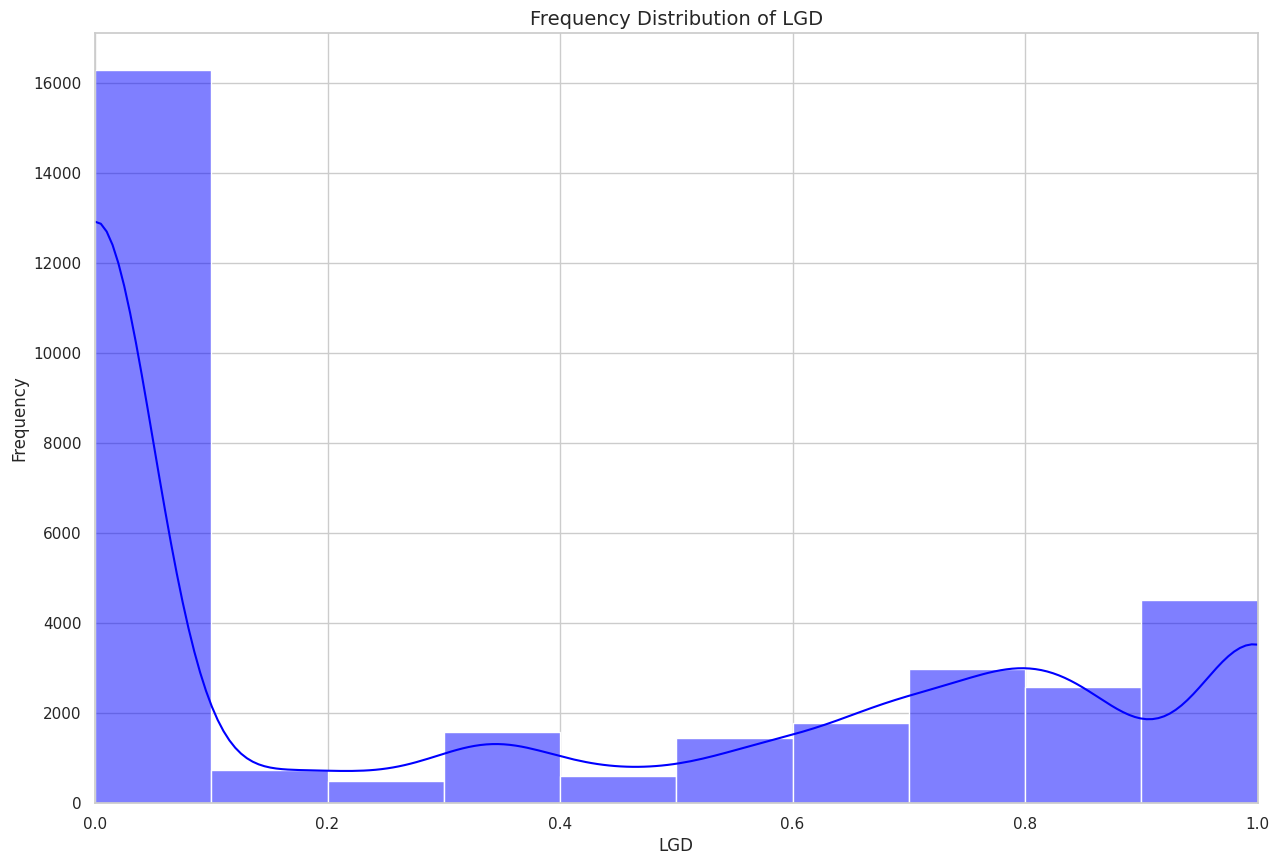

In [31]:
import seaborn as sns

# Set the style for seaborn plots
sns.set(style="whitegrid")

# Plot the frequency distribution (histogram) for the 'LGD' column
plt.figure(figsize=(15, 10))
sns.histplot(data['LGD'], bins=10, kde=True, color='blue')


# Set the x-axis range from 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.title('Frequency Distribution of LGD', fontsize=14)
plt.xlabel('LGD', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

# Save the DataFrame
data.to_csv('../datasets/Rural_LGD_Dataset.csv')


## Processing and Cleaning the Dataset

First, lets check the columns.

In [32]:
data.columns

Index(['Id', 'city', 'age', 'sex', 'social_class', 'primary_business',
       'secondary_business', 'annual_income', 'monthly_expenses',
       'old_dependents', 'young_dependents', 'home_ownership', 'type_of_house',
       'occupants_count', 'house_area', 'sanitary_availability',
       'water_availabity', 'loan_purpose', 'loan_tenure', 'loan_installments',
       'loan_amount', 'LTI', 'LSR', 'specific_net_income', 'LGD'],
      dtype='object')

Finally, drop the irrelevant columns and round the numerical columns.

In [33]:

# Columns to drop
columns_to_drop = ['city', 'social_class', 'primary_business', 'home_ownership', 'secondary_business', 'type_of_house', 'sanitary_availability', 'water_availabity', 'loan_purpose']

# Drop the columns
data = data.drop(columns=columns_to_drop)
data = data.round(4)

# Optionally save this dataset
data.to_csv("../datasets/Rural_LGD_Dataset.csv", index=False)

data.columns

Index(['Id', 'age', 'sex', 'annual_income', 'monthly_expenses',
       'old_dependents', 'young_dependents', 'occupants_count', 'house_area',
       'loan_tenure', 'loan_installments', 'loan_amount', 'LTI', 'LSR',
       'specific_net_income', 'LGD'],
      dtype='object')

In [7]:

# Handle categorical variables using one-hot encoding or label encoding
# One-hot encoding (e.g., for 'city', 'sex', 'social_class', etc.)
categorical_columns = ['sex']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Compute the correlation matrix
correlation_matrix = data.corr()

# Extract correlations with 'LGD'
lgd_correlation = correlation_matrix["LGD"].sort_values(ascending=False)

# Display the correlations
print("Correlations with LGD:\n", lgd_correlation)

Correlations with LGD:
 LGD                    1.000000
monthly_expenses       0.191222
loan_installments      0.084269
LTI                    0.041559
young_dependents       0.017464
occupants_count        0.008806
sex_TG                 0.003030
old_dependents        -0.006644
LSR                   -0.019470
house_area            -0.022794
loan_tenure           -0.025447
age                   -0.040861
loan_amount           -0.045704
sex_M                 -0.055181
Id                    -0.288034
specific_net_income   -0.354873
annual_income         -0.439291
Name: LGD, dtype: float64


From the dataset, the following columns are found to be significantly correlated,
- monthly_expenses
- specific_net_income
- annual_income

However, since every other column has 0 correlation, there is a high chance that the dataset represents non-linear connections.

In [8]:
data.head()

,Id,age,annual_income,monthly_expenses,old_dependents,young_dependents,occupants_count,house_area,loan_tenure,loan_installments,loan_amount,LTI,LSR,specific_net_income,LGD,sex_M,sex_TG
0,1,22,36000.0,5000.0,0,2,4,70.0,12,12,5000.0,0.1389,0.0833,-24000.0,0.7917,False,False
1,2,21,94000.0,3600.0,1,1,4,80.0,12,50,7500.0,0.0798,0.1736,50800.0,0.0000,False,False
2,3,24,48000.0,4000.0,0,2,4,50.0,12,12,5000.0,0.1042,0.1042,0.0,1.0000,True,False
4,5,23,36000.0,3500.0,0,0,1,112.0,12,12,5000.0,0.1389,0.1190,-6000.0,0.1667,False,False
5,6,23,36000.0,3500.0,0,0,1,112.0,12,12,5000.0,0.1389,0.1190,-6000.0,0.1667,False,False


## Machine Learning Model

First it is important to split the dataset into train, test and validation sets.

In [9]:
from sklearn.model_selection import train_test_split

# 1. Separate Features and Target
X = data.drop(columns=['LGD', 'Id'])  # Drop target and non-informative columns like 'Id'
y = data['LGD']

# 2. Split the Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Standardize and scale the data.

In [10]:
# 3. Standardize the Data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Ridge Regression

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# 4. Fit Ridge Regression
ridge_model = Ridge(alpha=100)  # Adjust alpha for regularization strength
ridge_model.fit(X_train_scaled, y_train)

# 5. Evaluate the Model
y_train_ridge = ridge_model.predict(X_train_scaled)
y_test_ridge = ridge_model.predict(X_test_scaled)

print("Train MSE:", mean_squared_error(y_train, y_train_ridge))
print("Test MSE:", mean_squared_error(y_test, y_test_ridge))

print("Train R^2:", r2_score(y_train, y_train_ridge))
print("Test R^2:", r2_score(y_test, y_test_ridge))

Train MSE: 0.1148860749126906
Test MSE: 0.1238852667720271
Train R^2: 0.28195425745745495
Test R^2: 0.23004263955216675


Find the appropriate hyperparameters.

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

print("Best alpha:", grid_search.best_params_['alpha'])

Best alpha: 100.0


### Lasso Regression

In [13]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Standardize the features (already done in your case)
scaler = StandardScaler()

# Fit Lasso Regression
lasso_model = Lasso(alpha=0.1)  # You can tune alpha for regularization strength
lasso_model.fit(X_train_scaled, y_train)

# Predict on validation and test sets
y_val_lasso = lasso_model.predict(X_val_scaled)
y_test_lasso = lasso_model.predict(X_test_scaled)

# Evaluate using MSE and R^2
mse_val = mean_squared_error(y_val, y_val_lasso)
r2_val = r2_score(y_val, y_val_lasso)

mse_test = mean_squared_error(y_test, y_test_lasso)
r2_test = r2_score(y_test, y_test_lasso)

# Output the results
print("Validation MSE:", mse_val)
print("Validation R^2:", r2_val)
print("Test MSE:", mse_test)
print("Test R^2:", r2_test)


Validation MSE: 0.1310343674166813
Validation R^2: 0.16695071486001034
Test MSE: 0.1350794726950443
Test R^2: 0.16046970752097878


In [14]:
from sklearn.pipeline import make_pipeline

lasso = make_pipeline(StandardScaler(), Lasso())

# Define the parameter grid for alpha
param_grid = {'lasso__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Set up GridSearchCV for cross-validation
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model with the best alpha
grid_search.fit(X_train, y_train)

# Get the best alpha and the corresponding model
best_alpha = grid_search.best_params_['lasso__alpha']
best_lasso_model = grid_search.best_estimator_

print("Best alpha for Lasso:", best_alpha)

# Evaluate on the validation set
y_val_lasso = best_lasso_model.predict(X_val_scaled)
print("Validation MSE for Lasso:", mean_squared_error(y_val, y_val_lasso))

Best alpha for Lasso: 0.01
Validation MSE for Lasso: 0.22478223127077077


/home/orientsvictor/grass/.env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### ElasticNet

In [15]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are already prepared (X for features and y for the target)

# Split data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data (important for regularized regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize ElasticNet model
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # alpha controls the overall strength of regularization, l1_ratio is the mix ratio between L1 and L2

# Fit the model
elastic_net_model.fit(X_train_scaled, y_train)

# Predict on validation and test sets
y_val_pred = elastic_net_model.predict(X_val_scaled)
y_test_pred = elastic_net_model.predict(X_test_scaled)

# Calculate metrics for validation set
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Print results
print("Validation MSE:", mse_val)
print("Validation R²:", r2_val)

# Optionally, check metrics for test set as well
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Test MSE:", mse_test)
print("Test R²:", r2_test)


Validation MSE: 0.1586566875074155
Validation R²: -0.0007689856997643574
Test MSE: 0.1581379032634908
Test R²: -5.3907012791398756e-05


### Linear Regressor

In [16]:
from sklearn.linear_model import LinearRegression

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features (important for linear regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Linear Regression model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_scaled, y_train)

# Predict on validation and test sets
y_val_pred = lin_reg_model.predict(X_val_scaled)
y_test_pred = lin_reg_model.predict(X_test_scaled)

# Evaluate the model
# MSE and R^2 for validation
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# MSE and R^2 for test
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f"Validation MSE: {val_mse}")
print(f"Validation R^2: {val_r2}")
print(f"Test MSE: {test_mse}")
print(f"Test R^2: {test_r2}")


Validation MSE: 0.1337492917942772
Validation R^2: 0.156340995202207
Test MSE: 0.12853036495911976
Test R^2: 0.18718225678648515


### DecisionTreeRegressor

In [17]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the DecisionTreeRegressor model
tree_model = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
tree_model.fit(X_train_scaled, y_train)

# Predict on validation and test sets
y_val_pred_tree = tree_model.predict(X_val_scaled)
y_test_pred_tree = tree_model.predict(X_test_scaled)

# Evaluate performance on the validation set
mse_val_tree = mean_squared_error(y_val, y_val_pred_tree)
r2_val_tree = r2_score(y_val, y_val_pred_tree)

# Evaluate performance on the test set
mse_test_tree = mean_squared_error(y_test, y_test_pred_tree)
r2_test_tree = r2_score(y_test, y_test_pred_tree)

# Print the results
print("Validation MSE (Decision Tree):", mse_val_tree)
print("Validation R^2 (Decision Tree):", r2_val_tree)
print("Test MSE (Decision Tree):", mse_test_tree)
print("Test R^2 (Decision Tree):", r2_test_tree)

Validation MSE (Decision Tree): 0.00015249625604838715
Validation R^2 (Decision Tree): 0.9990380895637858
Test MSE (Decision Tree): 0.0002932889798387097
Test R^2 (Decision Tree): 0.9981452593962702


In [18]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters for tuning
param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # Limit the depth
    'min_samples_split': [2, 5, 10],     # Require more samples to split
    'min_samples_leaf': [1, 2, 5],       # Require more samples in each leaf
    'max_leaf_nodes': [None, 10, 20],    # Limit the number of leaf nodes
    'ccp_alpha': [0.0, 0.01, 0.1]       # Prune branches
}

# Initialize the DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_tree_model = grid_search.best_estimator_

# Predict on the validation and test sets
y_val_pred_tree = best_tree_model.predict(X_val_scaled)
y_test_pred_tree = best_tree_model.predict(X_test_scaled)

# Evaluate performance
mse_val_tree = mean_squared_error(y_val, y_val_pred_tree)
r2_val_tree = r2_score(y_val, y_val_pred_tree)
mse_test_tree = mean_squared_error(y_test, y_test_pred_tree)
r2_test_tree = r2_score(y_test, y_test_pred_tree)

# Print the results
print("Best Parameters (Decision Tree):", grid_search.best_params_)
print("Validation MSE (Decision Tree):", mse_val_tree)
print("Validation R^2 (Decision Tree):", r2_val_tree)
print("Test MSE (Decision Tree):", mse_test_tree)
print("Test R^2 (Decision Tree):", r2_test_tree)

Best Parameters (Decision Tree): {'ccp_alpha': 0.0, 'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Validation MSE (Decision Tree): 0.0001459726486586645
Validation R^2 (Decision Tree): 0.9990792389414331
Test MSE (Decision Tree): 0.00016666824269460367
Test R^2 (Decision Tree): 0.9989460007762719


### XGBoost

In [19]:
import xgboost as xgb

# Prepare the data
X_train_scaled, X_val_scaled, X_test_scaled = X_train_scaled, X_val_scaled, X_test_scaled  # Make sure these are scaled

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_val_pred = xgb_model.predict(X_val_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
print("Validation MSE:", mean_squared_error(y_val, y_val_pred))
print("Validation R^2:", r2_score(y_val, y_val_pred))

# You can also evaluate the test set:
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))

Validation MSE: 0.00022057866611330894
Validation R^2: 0.9986086417697149
Test MSE: 0.00022421707347245511
Test R^2: 0.9985820656799054


### Random Forest, SVM And MLP

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
print("Random Forest Validation MSE:", mean_squared_error(y_val, y_val_pred_rf))
print("Random Forest Validation R²:", r2_score(y_val, y_val_pred_rf))
print("Random Forest Test R²:", r2_score(y_test, y_test_pred_rf))

Random Forest Validation MSE: 0.0001070831039715726
Random Forest Validation R²: 0.9993245450221429
Random Forest Test R²: 0.9988559234641281


In [21]:
from sklearn.svm import SVR

# Support Vector Regressor
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Adjust C and epsilon as needed
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_val_pred_svm = svm_model.predict(X_val_scaled)
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Metrics
print("SVM Validation MSE:", mean_squared_error(y_val, y_val_pred_svm))
print("SVM Validation R²:", r2_score(y_val, y_val_pred_svm))
print("SVM Test R²:", r2_score(y_test, y_test_pred_svm))

SVM Validation MSE: 0.07115164614134901
SVM Validation R²: 0.5511921882497497
SVM Test R²: 0.5373402069755149


In [22]:
from sklearn.neural_network import MLPRegressor

# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_train)

# Predictions
y_val_pred_nn = nn_model.predict(X_val_scaled)
y_test_pred_nn = nn_model.predict(X_test_scaled)

# Metrics
print("Neural Network Validation MSE:", mean_squared_error(y_val, y_val_pred_nn))
print("Neural Network Validation R²:", r2_score(y_val, y_val_pred_nn))
print("Neural Network Test R²:", r2_score(y_test, y_test_pred_nn))

Neural Network Validation MSE: 0.002015637070350572
Neural Network Validation R²: 0.9872858364930927
Neural Network Test R²: 0.7625856552504077


### Final Model

All of the following,
- XGBoost
- DecisionTreeRegressor
- Random Forest
- Neural Networks

gave us fairly good results. For our purposes, we will go ahead with Random Forest.

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Reduced parameter distribution to speed up the search
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Initialize RandomForest model
rf_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV with fewer iterations and cross-validation folds
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=20, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters from random search
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Best model
best_rf_model = random_search.best_estimator_

# Predictions on validation and test data
y_val_pred_rf = best_rf_model.predict(X_val)
y_test_pred_rf = best_rf_model.predict(X_test)

# Metrics
print("Random Forest Validation MSE:", mean_squared_error(y_val, y_val_pred_rf))
print("Random Forest Validation R²:", r2_score(y_val, y_val_pred_rf))
print("Random Forest Test R²:", r2_score(y_test, y_test_pred_rf))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=89; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=89; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=89; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=9, min_samples_split=9, n_estimators=51; total time=   1.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=9, min_samples_split=9, n_estimators=51; total time=   1.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=9, min_samples_split=9, n_estimators=51; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=9, min_samples_split=8, n_estimators=74; to

/home/orientsvictor/grass/.env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/orientsvictor/grass/.env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/orientsvictor/grass/.env/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/orientsvictor/grass/.env/lib/python3.1

Best Parameters from RandomizedSearchCV: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 76}
Random Forest Validation MSE: 0.0018489786561033355
Random Forest Validation R²: 0.9883370784848728
Random Forest Test R²: 0.9861488484107326


In [24]:
X_train

,age,annual_income,monthly_expenses,old_dependents,young_dependents,occupants_count,house_area,loan_tenure,loan_installments,loan_amount,LTI,LSR,specific_net_income,sex_M,sex_TG
12865,38,48000.0,2500.0,0,2,1,450.0,12,12,7000.0,0.1458,0.2333,18000.0,False,False
34961,32,72000.0,5000.0,0,3,5,400.0,12,12,8000.0,0.1111,0.1333,12000.0,False,False
13243,30,9600.0,4700.0,0,2,4,400.0,12,50,5000.0,0.5208,0.0887,-46800.0,False,False
5302,22,36000.0,3000.0,0,1,1,112.0,12,12,5000.0,0.1389,0.1389,0.0,False,False
34301,54,48000.0,2500.0,0,2,2,300.0,12,12,10000.0,0.2083,0.3333,18000.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22754,27,14400.0,4400.0,0,1,3,300.0,12,50,10000.0,0.6944,0.1894,-38400.0,False,False
6538,46,60000.0,4200.0,0,2,5,900.0,12,12,5000.0,0.0833,0.0992,9600.0,True,False
16845,21,18000.0,3500.0,0,1,3,700.0,12,12,5000.0,0.2778,0.1190,-24000.0,False,False
928,23,30000.0,2500.0,0,1,2,112.0,12,12,5000.0,0.1667,0.1667,0.0,False,False


In [25]:
# Predict
pred = best_rf_model.predict([[19, 78399, 14000, 0, 0, 1, 100, 12, 12, 10000000, 1.27, 0.47, -788886, True, False]])
print("Prediction:", pred)

Prediction: [0.53959003]


/home/orientsvictor/grass/.env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
